In [1]:
model_name = 'jplu/tf-xlm-r-ner-40-lang'
tokenizer_name = model_name

In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
if model_name == 't5-large':
    EPOCHs = 1
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
else:
    EPOCHS = 3
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync


MAX_LEN = 128

# Create fast tokenizer

In [5]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name)
if model_name == 't5-large':
    tokenizer.pad_token = tokenizer.eos_token

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# fast_tokenizer = SentencePieceBPETokenizer('vocab.txt')
# fast_tokenizer

('./sentencepiece.bpe.model',
 './special_tokens_map.json',
 './added_tokens.json')

# Load text data into memory


## Jigsaw

In [6]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


In [7]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])
print(train.toxic.value_counts())
print(valid.toxic.value_counts())

0    352165
1    133610
Name: toxic, dtype: int64
0    6770
1    1230
Name: toxic, dtype: int64


## OLID

In [9]:
olid = pd.read_csv('/kaggle/input/olid2019/olid-training-v1.0.tsv', sep='\t')
olid = olid.rename(columns={"id": "id", "tweet": "comment_text", 'subtask_a': 'toxic'})
olid.toxic = (olid.toxic == 'OFF').astype(int)
# olid['comment_text'] = olid['comment_text'].str.replace('@USER', '')
olid.head()

,id,comment_text,toxic,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN


In [10]:
olid_test = pd.read_csv('/kaggle/input/olid2019/testset-levela.tsv', sep='\t')
olid_test_label = pd.read_csv('/kaggle/input/olid2019/labels-levela.csv', names = ['id', 'label'])

In [11]:
olid_test_label.label.value_counts()

NOT    620
OFF    240
Name: label, dtype: int64

In [12]:
olid_test = olid_test.set_index('id').join(olid_test_label.set_index('id'))

In [13]:
olid_test['toxic'] = (olid_test.label == 'OFF').astype(int).values

In [14]:
olid_test.head()

,tweet,label,toxic
id,,,
15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,1
27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,0
30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,0
13876,#Watching #Boomer getting the news that she is...,NOT,0
60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,1


In [15]:
from sklearn.model_selection import train_test_split
olid_train, olid_valid = train_test_split(olid, test_size=3240, random_state = 2020)
olid_train_1k = olid_train[0:1000]
olid_train_2k = olid_train[0:2000]
olid_train_5k = olid_train[0:5000]


## Encode them

In [16]:
def fast_encode_xlm(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk, pad_to_max_length = True, max_length = maxlen)
        all_ids.extend(np.array(encs.input_ids))
    
    return np.array(all_ids)

In [17]:
x_train = fast_encode_xlm(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode_xlm(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode_xlm(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [18]:
# olid_encode = fast_encode_xlm(olid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_encode = fast_encode_xlm(olid_train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_1k_encode = fast_encode_xlm(olid_train_1k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_2k_encode = fast_encode_xlm(olid_train_2k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_5k_encode = fast_encode_xlm(olid_train_5k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_valid_encode = fast_encode_xlm(olid_valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_test_encode = fast_encode_xlm(olid_test.tweet.astype(str), tokenizer, maxlen = MAX_LEN)


In [19]:
y_olid_train = olid_train.toxic.values
y_olid_train_1k = olid_train_1k.toxic.values
y_olid_train_2k = olid_train_2k.toxic.values
y_olid_train_5k = olid_train_5k.toxic.values
y_olid_valid = olid_valid.toxic.values
y_olid_test = (olid_test_label.label == 'OFF').astype(int).values

# Build datasets objects

In [20]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [21]:
olid_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(olid_test_encode)
    .batch(BATCH_SIZE)
)
olid_valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_valid_encode, y_olid_valid))
    .batch(BATCH_SIZE)
)
olid_train_1k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_1k_encode, y_olid_train_1k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_2k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_2k_encode, y_olid_train_2k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_5k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_5k_encode, y_olid_train_5k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_encode, y_olid_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


# Load model into the TPU


In [22]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    
    return model

In [23]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFAutoModelWithLMHead.from_pretrained(model_name)
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_roberta_for_masked_lm (TF ((None, 128, 250002),)    278885778 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 250002)]          0         
_________________________________________________________________
dense (Dense)                (None, 1)                 250003    
Total params: 279,135,781
Trainable params: 279,135,781
Non-trainable params: 0
_________________________________________________________________
CPU times: user 51.3 s, sys: 21.5 s, total: 1min 12s
Wall time: 1min 16s


In [24]:
# tf.tpu.experimental.initialize_tpu_system(tpu)

# Train Model

In [25]:
n_steps = x_train.shape[0] // BATCH_SIZE
model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


3795/3795 [==============================] - 977s 257ms/step - accuracy: 0.9673 - loss: 0.1116 - val_accuracy: 0.8480 - val_loss: 0.8223
Epoch 2/3
3795/3795 [==============================] - 953s 251ms/step - accuracy: 0.9754 - loss: 0.0772 - val_accuracy: 0.8439 - val_loss: 0.4660
Epoch 3/3
3795/3795 [==============================] - 955s 252ms/step - accuracy: 0.9778 - loss: 0.0699 - val_accuracy: 0.8565 - val_loss: 0.5421


In [26]:
n_steps = x_valid.shape[0] // BATCH_SIZE
model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/3
62/62 [==============================] - 15s 245ms/step - accuracy: 0.8325 - loss: 0.9234
Epoch 2/3
62/62 [==============================] - 15s 245ms/step - accuracy: 0.8897 - loss: 0.3615
Epoch 3/3
62/62 [==============================] - 15s 244ms/step - accuracy: 0.8999 - loss: 0.3858


# Submission

In [27]:
sub['toxic'] = model.predict(test_dataset, verbose=0)
sub.to_csv('submission.csv', index=False)

In [28]:
sub.describe()

,id,toxic
count,63812.000000,6.381200e+04
mean,31905.500000,7.218959e-02
std,18421.082026,2.298730e-01
min,0.000000,0.000000e+00
25%,15952.750000,1.788139e-07
50%,31905.500000,5.930662e-06
75%,47858.250000,1.847483e-03
max,63811.000000,1.000000e+00


# Olid Zero-shot

In [29]:
from sklearn.metrics import roc_auc_score

In [30]:
olid_test.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test.to_csv('olid_test_0shot.csv', index=False)

roc_auc_score(y_true = olid_test.toxic, y_score = olid_test.toxic_predict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


0.862231182795699

In [31]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(olid_test.toxic, olid_test.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test.toxic_predict]

the optimal threshold is 0.00012096762657165527


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [32]:
f1_score(y_true = olid_test.toxic, y_pred = olid_test.toxic_predict_binary)


0.6501766784452297

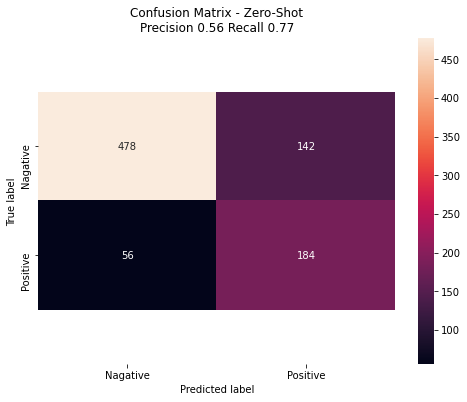

In [33]:
def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_matrix(olid_test.toxic, olid_test.toxic_predict_binary, name = 'Zero-Shot')


# Olid Few-shot

In [34]:
model.save_weights("/kaggle/working/ckpt.h5")
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[4.2423606e-04],
       [2.1994114e-05],
       [1.3828278e-05],
       [3.9637089e-06],
       [1.3649464e-05]], dtype=float32)

In [35]:
with strategy.scope():
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
n_steps = olid_train_1k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_1k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test1k = olid_test
olid_test1k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test1k.to_csv('olid_test_1k.csv', index=False)

print('1k roc is ' + str(roc_auc_score(y_true = olid_test1k.toxic, y_score = olid_test1k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test1k.toxic, olid_test1k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test1k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test1k.toxic_predict]

print('1k f1-score is ' + str(f1_score(y_true = olid_test1k.toxic, y_pred = olid_test1k.toxic_predict_binary)))


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


7/7 [==============================] - 29s 4s/step - accuracy: 0.7310 - loss: 0.9893 - val_accuracy: 0.7302 - val_loss: 0.8474
Epoch 2/10
7/7 [==============================] - 9s 1s/step - accuracy: 0.7546 - loss: 0.7337 - val_accuracy: 0.7883 - val_loss: 0.8121
Epoch 3/10
7/7 [==============================] - 8s 1s/step - accuracy: 0.7867 - loss: 0.5787 - val_accuracy: 0.7627 - val_loss: 0.6331
Epoch 4/10
7/7 [==============================] - 8s 1s/step - accuracy: 0.7844 - loss: 0.5264 - val_accuracy: 0.7861 - val_loss: 0.6229
Epoch 5/10
7/7 [==============================] - 7s 1s/step - accuracy: 0.7982 - loss: 0.4914 - val_accuracy: 0.7762 - val_loss: 0.5329
Epoch 6/10
7/7 [==============================] - 4s 579ms/step - accuracy: 0.7901 - loss: 0.4699 - val_accuracy: 0.7877 - val_loss: 0.5333
Epoch 7/10
7/7 [==============================] - 8s 1s/step - accuracy: 0.7856 - loss: 0.4599 - val_accuracy: 0.7778 - val_loss: 0.5032
Epoch 8/10
7/7 [==============================] 

In [36]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[4.2423606e-04],
       [2.1994114e-05],
       [1.3828278e-05],
       [3.9637089e-06],
       [1.3649464e-05]], dtype=float32)

In [37]:
n_steps = olid_train_2k.shape[0] // BATCH_SIZE
model.fit(
    olid_train_2k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test2k = olid_test
olid_test2k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test2k.to_csv('olid_test_2k.csv', index=False)

print('2k roc is ' + str(roc_auc_score(y_true = olid_test2k.toxic, y_score = olid_test2k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test2k.toxic, olid_test2k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test2k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test2k.toxic_predict]

print('2k f1-score is ' + str(f1_score(y_true = olid_test2k.toxic, y_pred = olid_test2k.toxic_predict_binary)))


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


15/15 [==============================] - 29s 2s/step - accuracy: 0.7599 - loss: 0.8071 - val_accuracy: 0.7880 - val_loss: 0.7279
Epoch 2/10
15/15 [==============================] - 11s 745ms/step - accuracy: 0.7890 - loss: 0.5441 - val_accuracy: 0.7827 - val_loss: 0.5645
Epoch 3/10
15/15 [==============================] - 9s 632ms/step - accuracy: 0.7890 - loss: 0.4727 - val_accuracy: 0.7818 - val_loss: 0.5063
Epoch 4/10
15/15 [==============================] - 10s 646ms/step - accuracy: 0.7949 - loss: 0.4643 - val_accuracy: 0.7858 - val_loss: 0.4984
Epoch 5/10
15/15 [==============================] - 10s 649ms/step - accuracy: 0.8002 - loss: 0.4501 - val_accuracy: 0.7864 - val_loss: 0.4955
Epoch 6/10
15/15 [==============================] - 10s 651ms/step - accuracy: 0.7959 - loss: 0.4460 - val_accuracy: 0.7873 - val_loss: 0.4898
Epoch 7/10
15/15 [==============================] - 10s 639ms/step - accuracy: 0.7981 - loss: 0.4244 - val_accuracy: 0.7895 - val_loss: 0.4846
Epoch 8/10
15/

In [38]:
tf.tpu.experimental.initialize_tpu_system(tpu)
with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[4.2423606e-04],
       [2.1994114e-05],
       [1.3828278e-05],
       [3.9637089e-06],
       [1.3649464e-05]], dtype=float32)

In [39]:
n_steps = olid_train_5k.shape[0] // BATCH_SIZE 
model.fit(
    olid_train_5k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test5k = olid_test
olid_test5k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test5k.to_csv('olid_test_5k.csv', index=False)

print('5k roc is ' + str(roc_auc_score(y_true = olid_test5k.toxic, y_score = olid_test5k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test5k.toxic, olid_test5k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test5k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test5k.toxic_predict]

print('5k f1-score is ' + str(f1_score(y_true = olid_test5k.toxic, y_pred = olid_test5k.toxic_predict_binary)))

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


39/39 [==============================] - 36s 911ms/step - accuracy: 0.7845 - loss: 0.6251 - val_accuracy: 0.7870 - val_loss: 0.5251
Epoch 2/10
39/39 [==============================] - 16s 399ms/step - accuracy: 0.7997 - loss: 0.4676 - val_accuracy: 0.7886 - val_loss: 0.4911
Epoch 3/10
39/39 [==============================] - 15s 389ms/step - accuracy: 0.8021 - loss: 0.4485 - val_accuracy: 0.7907 - val_loss: 0.4823
Epoch 4/10
39/39 [==============================] - 15s 389ms/step - accuracy: 0.8118 - loss: 0.4439 - val_accuracy: 0.7932 - val_loss: 0.4723
Epoch 5/10
39/39 [==============================] - 15s 386ms/step - accuracy: 0.8149 - loss: 0.4381 - val_accuracy: 0.7901 - val_loss: 0.4719
Epoch 6/10
39/39 [==============================] - 12s 309ms/step - accuracy: 0.8091 - loss: 0.4350 - val_accuracy: 0.7886 - val_loss: 0.4899
Epoch 7/10
39/39 [==============================] - 12s 310ms/step - accuracy: 0.8151 - loss: 0.4280 - val_accuracy: 0.7963 - val_loss: 0.4728
Epoch 8/10

In [40]:
tf.tpu.experimental.initialize_tpu_system(tpu)

with strategy.scope():
    model.load_weights("/kaggle/working/ckpt.h5") 
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
model.predict(olid_test_dataset, verbose=0)[0:5]

array([[4.2423606e-04],
       [2.1994114e-05],
       [1.3828278e-05],
       [3.9637089e-06],
       [1.3649464e-05]], dtype=float32)

In [41]:
n_steps = olid_train.shape[0] // BATCH_SIZE
model.fit(
    olid_train_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_valid_dataset,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    epochs=10
)

olid_test10k = olid_test
olid_test10k.toxic_predict = model.predict(olid_test_dataset, verbose=0)
olid_test10k.to_csv('olid_test_10k.csv', index=False)

print('10k roc is ' + str(roc_auc_score(y_true = olid_test10k.toxic, y_score = olid_test10k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test10k.toxic, olid_test10k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test10k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test10k.toxic_predict]

print('10k f1-score is ' + str(f1_score(y_true = olid_test10k.toxic, y_pred = olid_test10k.toxic_predict_binary)))


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


78/78 [==============================] - 45s 572ms/step - accuracy: 0.7787 - loss: 0.5556 - val_accuracy: 0.7870 - val_loss: 0.4946
Epoch 2/10
78/78 [==============================] - 25s 317ms/step - accuracy: 0.7973 - loss: 0.4519 - val_accuracy: 0.7948 - val_loss: 0.4785
Epoch 3/10
78/78 [==============================] - 22s 279ms/step - accuracy: 0.8014 - loss: 0.4438 - val_accuracy: 0.7969 - val_loss: 0.4816
Epoch 4/10
78/78 [==============================] - 25s 320ms/step - accuracy: 0.8053 - loss: 0.4324 - val_accuracy: 0.7972 - val_loss: 0.4747
Epoch 5/10
78/78 [==============================] - 25s 324ms/step - accuracy: 0.8119 - loss: 0.4270 - val_accuracy: 0.7985 - val_loss: 0.4686
Epoch 6/10
78/78 [==============================] - 25s 325ms/step - accuracy: 0.8131 - loss: 0.4221 - val_accuracy: 0.8009 - val_loss: 0.4676
Epoch 7/10
78/78 [==============================] - 25s 327ms/step - accuracy: 0.8179 - loss: 0.4131 - val_accuracy: 0.7954 - val_loss: 0.4584
Epoch 8/10